In [1]:
# Experiment 1: Visual Place Recognition with Positive Transformation
# Dataset: GardensPointWalking (day_left vs night_right)
# Feature Descriptors: DELF-HDC
# Descriptor Dimensions: 4096
# Transformation: Positive shift with normalization
# Purpose: Evaluate impact of positive transformation on VPR performance

In [2]:
from scipy.io import loadmat, savemat
from scipy.linalg import orth
import numpy as np
import faiss
from scipy.spatial.distance import cdist
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import gc
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'lib')))

from randn2 import randn2 
import peer_functions as peer
from dot_product import CPUDotProduct, LoihiDotProductSimulationPositive, CPUDotProductPositive
from dot_product import ScaleQuery, ScaleDatabase

import math
from tqdm import tqdm
os.environ['OPENBLAS_NUM_THREADS'] = '1'

c:\Users\21361535\AppData\Local\anaconda3\envs\lava3\lib\site-packages\lava\utils\profiler.py:16: UserWarning: Loihi2HWProfiler could not be imported. Currently no profiler is available.
  warnings.warn("Loihi2HWProfiler could not be imported. "


In [3]:
def calculate_evaluation_metrics(similarity_matrix, ground_truth):
    """
    Calculate evaluation metrics for place recognition results
    
    Args:
        similarity_matrix: Matrix of similarity scores between queries and database
        ground_truth: Ground truth data containing GThard and GTsoft
        
    Returns:
        dict: Dictionary containing recalls, precision, recall curves and AUC
    """
    # Get candidate selections
    ids_pos = peer.directCandSel(similarity_matrix)
    
    # Calculate recall values
    recalls = peer.getRecallAtKVector(ids_pos, ground_truth["GT"])
    
    # Calculate precision-recall curves and AUC
    [R, P] = peer.createPR(-similarity_matrix, 
                          ground_truth['GT']["GThard"][0][0], 
                          ground_truth['GT']["GTsoft"][0][0])
    auc = np.trapz(P, R)
    
    return {
        'recalls': recalls,
        'precision': P,
        'recall': R,
        'auc': auc
    }


In [4]:
D1    = loadmat("../datasets/descriptors/GardensPointWalking/day_left/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
D2    = loadmat("../datasets/descriptors/GardensPointWalking/night_right/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']

g_truth = loadmat("../datasets/ground_truth/GardensPointWalking/day_left--night_right/gt.mat")

## Original VPR

In [5]:
normalizer = Normalizer()

mu1 = np.mean(D1,axis=0)

D1_centered = np.subtract(D1,mu1)  # database
D1_norm = normalizer.fit_transform(D1_centered)

D2_centered = np.subtract(D2,mu1)
D2_norm = normalizer.fit_transform(D2_centered)

In [6]:
DD = cdist(D1_norm, D2_norm, 'cosine')

In [7]:
metrics = calculate_evaluation_metrics(DD, g_truth)
print(f"AUC: {metrics['auc']}")


AUC: 0.4702147082864312


In [8]:
0.4702147082864312

0.4702147082864312

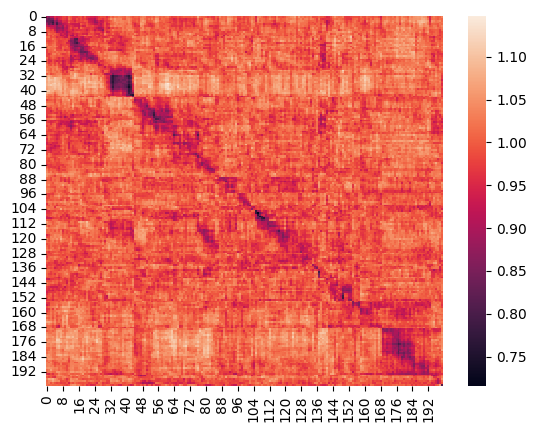

In [9]:
import seaborn as sns

ax = sns.heatmap(DD)
plt.show()

## CPU Dot Product

In [10]:
import time

dot = CPUDotProduct(D1, D2)


# Measure CPU Dot Product execution time
start_time = time.time()

DD = dot.run()

end_time = time.time()

In [11]:
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.4f} seconds")

Execution time: 0.0810 seconds


In [12]:
metrics = calculate_evaluation_metrics(DD, g_truth)
print(f"AUC: {metrics['auc']}")

AUC: 0.4702147082864312


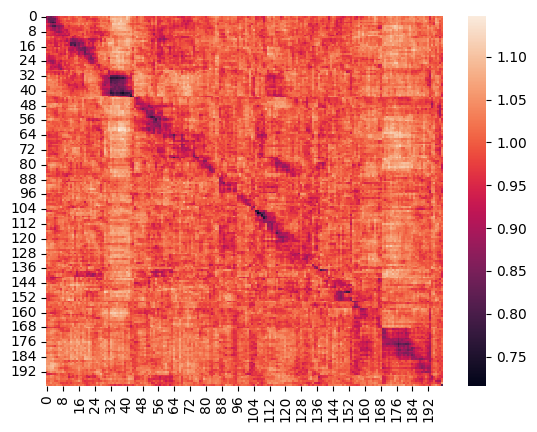

In [13]:
import seaborn as sns

ax = sns.heatmap(DD)
plt.show()

## Positive Transformation

In [14]:
constant = 1/math.sqrt(2)

dot = CPUDotProductPositive(D1, D2, constant)
# dot = CPUDotProduct(D1, D2)


In [15]:
DD = dot.run()

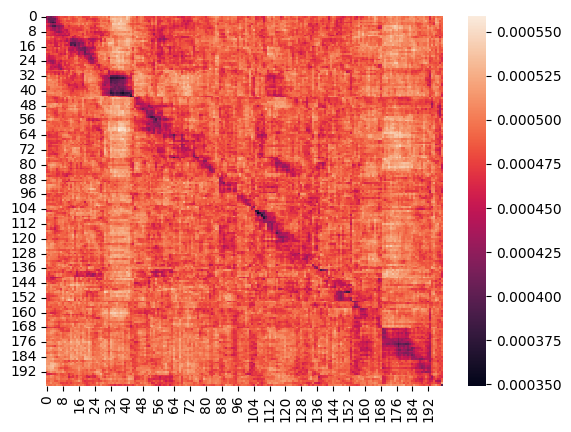

In [16]:
import seaborn as sns

ax = sns.heatmap(DD)
plt.show()

In [17]:

metrics = calculate_evaluation_metrics(DD, g_truth)
print(f"AUC: {metrics['auc']}")

# You can also access other metrics if needed:
# print(f"Recalls: {metrics['recalls']}")
# print(f"Precision: {metrics['precision']}")
# print(f"Recall: {metrics['recall']}")

AUC: 0.4660135714632877


In [18]:
cpu_time = 0.0810 * 1000
loihi_time = 21.908

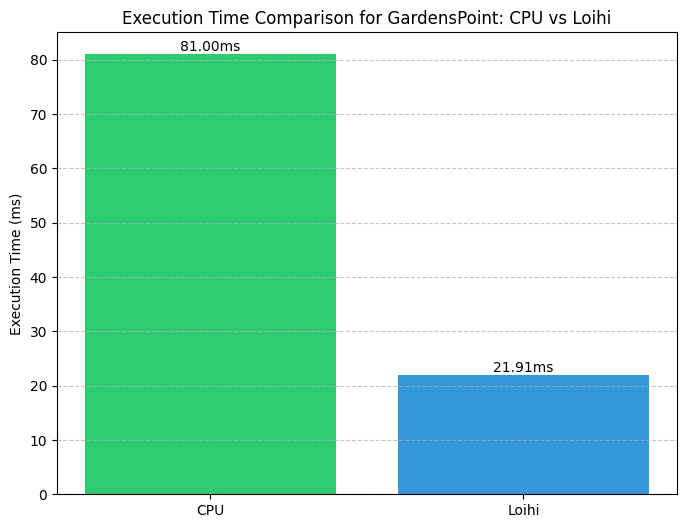

In [20]:
# Create bar plot comparing execution times
plt.figure(figsize=(8, 6))
times = [cpu_time, loihi_time]
labels = ['CPU', 'Loihi']
plt.bar(labels, times, color=['#2ecc71', '#3498db'])

# Add value labels on top of each bar
for i, v in enumerate(times):
    plt.text(i, v, f'{v:.2f}ms', ha='center', va='bottom')

plt.ylabel('Execution Time (ms)')
plt.title('Execution Time Comparison for GardensPoint: CPU vs Loihi')

# Optional: Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

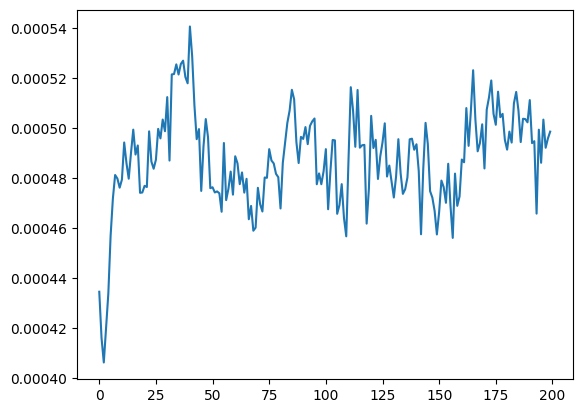

In [21]:
plt.plot(DD[0])

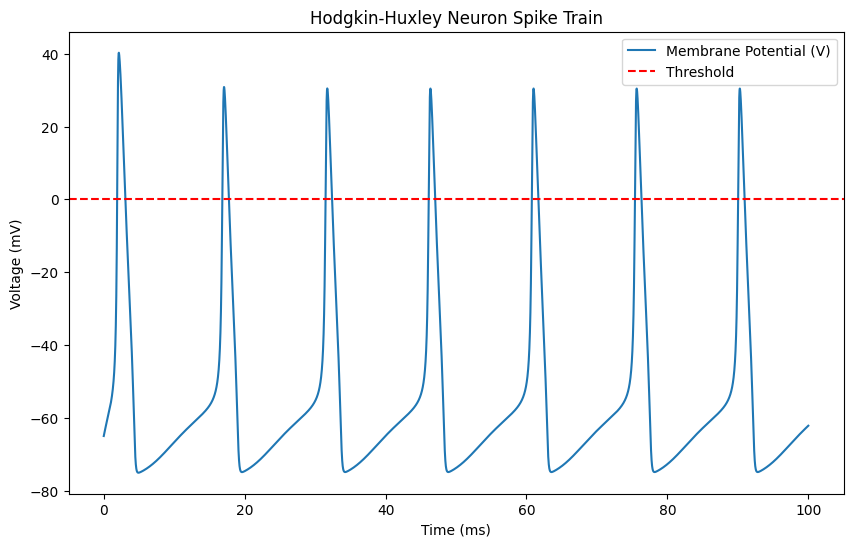

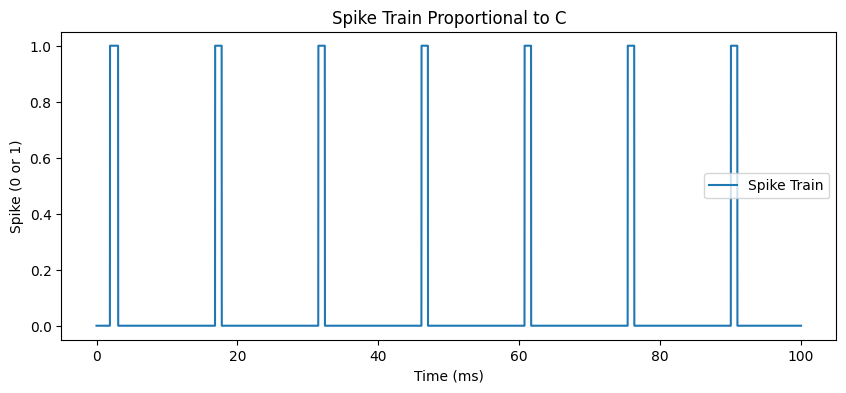

In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.integrate import odeint

# # Define constants for the HH model
# C_m = 1.0  # Membrane capacitance, uF/cm^2
# g_Na = 120.0  # Maximum conductances, mS/cm^2
# g_K = 36.0
# g_L = 0.3
# E_Na = 50.0  # Reversal potentials, mV
# E_K = -77.0
# E_L = -54.4

# # Define gating variable functions
# def alpha_m(V):
#     return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))

# def beta_m(V):
#     return 4.0 * np.exp(-(V + 65) / 18)

# def alpha_h(V):
#     return 0.07 * np.exp(-(V + 65) / 20)

# def beta_h(V):
#     return 1 / (1 + np.exp(-(V + 35) / 10))

# def alpha_n(V):
#     return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))

# def beta_n(V):
#     return 0.125 * np.exp(-(V + 65) / 80)

# # HH model equations
# def hh_model(y, t, I_ext):
#     V, m, h, n = y
    
#     # Gating variables
#     dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
#     dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
#     dndt = alpha_n(V) * (1 - n) - beta_n(V) * n

#     # Ionic currents
#     I_Na = g_Na * m**3 * h * (V - E_Na)
#     I_K = g_K * n**4 * (V - E_K)
#     I_L = g_L * (V - E_L)

#     # Voltage equation
#     dVdt = (I_ext - I_Na - I_K - I_L) / C_m

#     return [dVdt, dmdt, dhdt, dndt]

# # Simulation parameters
# t = np.linspace(0, 100, 10000)  # Time, ms
# C = 10.0  # Value to control firing rate
# k = 1.0  # Scaling factor for I_ext
# I_ext = k * C  # External current, uA/cm^2

# # Initial conditions
# V0 = -65.0  # Initial membrane potential, mV
# m0 = alpha_m(V0) / (alpha_m(V0) + beta_m(V0))
# h0 = alpha_h(V0) / (alpha_h(V0) + beta_h(V0))
# n0 = alpha_n(V0) / (alpha_n(V0) + beta_n(V0))
# initial_conditions = [V0, m0, h0, n0]

# # Solve the HH model
# y = odeint(hh_model, initial_conditions, t, args=(I_ext,))

# # Extract voltage and plot
# threshold = 0  # Define spike threshold
# voltage = y[:, 0]
# spike_times = t[voltage > threshold]

# plt.figure(figsize=(10, 6))
# plt.plot(t, voltage, label="Membrane Potential (V)")
# plt.axhline(threshold, color="r", linestyle="--", label="Threshold")
# plt.title("Hodgkin-Huxley Neuron Spike Train")
# plt.xlabel("Time (ms)")
# plt.ylabel("Voltage (mV)")
# plt.legend()
# plt.show()

# # Generate spike train
# spike_train = (voltage > threshold).astype(int)
# plt.figure(figsize=(10, 4))
# plt.plot(t, spike_train, label="Spike Train")
# plt.title("Spike Train Proportional to C")
# plt.xlabel("Time (ms)")
# plt.ylabel("Spike (0 or 1)")
# plt.legend()
# plt.show()
